<a href="https://colab.research.google.com/github/olcaykursun/ML/blob/main/Fall2025/Week5/linear_regression_nRMSE_R2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regression on Iris: Sepal Length, nRMSE, and R²

We want to study how well **sepal length** can be predicted
from the other three features (sepal width, petal length, petal width)
within each Iris species (setosa, versicolor, virginica).

- We will train a separate **linear regression model** for each class.
- To evaluate each model fairly, we will use **Leave-One-Out Cross-Validation (LOOCV)**.  
  This means: for each example in the dataset, we leave it out of the training set, train the model on all the other examples, and then test on the left-out one. We repeat this in a round-robin fashion until every example has served once as the test case.
- For each class, we will compute:
  - RMSE (in cm, same units as the target),
  - SD(y) (natural variability of sepal length in that class),
  - nRMSE = RMSE / SD(y) (scale-free comparison),
  - R² (variance explained by the model, also known as coefficient of determination),
  - correlation between true and predicted values.

At the end, we will compare classes and see which one is best predicted.


In [1]:
# We will accumulate results for each class in these lists.
# For each class we will train a separate regressor.
results = []
scatter_payloads = []  # (class-label, y_true, y_pred) for the plots


In [2]:
# Three ways to load Iris (each for a different class) + unified LOOCV evaluation
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# ---------------------------
# Helper: evaluate one class
# ---------------------------
def evaluate_class(X, y, label):
    """
    X: 2D array of predictors (n, p)
    y: 1D array target (n,)
    label: string for the class name
    """
    loo = LeaveOneOut()
    model = LinearRegression()
    y_pred = cross_val_predict(model, X, y, cv=loo)

    mse  = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    sd = np.std(y, ddof=1)  # Sample std (N-1 in denominator, since 1 DOF is lost estimating the mean)

    # MSE has squared units (it calculates the average of (y - y_pred)**2).
    # RMSE brings it back to the same units as the target, but is it large or small?
    # Compare it to the standard deviation of y to get nRMSE, which is more interpretable.
    nrmse = rmse / sd if sd > 0 else np.nan

    # R^2 is the standard measure of variance explained.
    # It is directly related to nRMSE and is safer to use on held-out/test predictions.
    r2_sklearn = r2_score(y, y_pred)

    # You can also look at the correlation between true and predicted values.
    # Squared correlation (r^2) may differ from R^2 under CV/test evaluation.
    r, _ = pearsonr(y, y_pred)
    r2_from_corr = r**2

    return {
        "class": label,
        "MSE": mse,
        "RMSE": rmse,
        "SD": sd,
        "nRMSE": nrmse,
        "1-nRMSE^2": 1 - nrmse**2,
        "R^2": r2_sklearn,
        "corr": r,
        "squared corr": r2_from_corr,
}, y, y_pred


# Dummy example with random data (10 samples, 2 features)
X_dummy = np.random.rand(10, 2)
y_dummy = np.random.rand(10)

evaluate_class(X_dummy, y_dummy, "dummy")

# As you can see, trying to predict random things from random things
# gave us an RMSE that looks "small" (maybe ~0.1).
# But is that actually good?
# Small compared to what? => We need a reference: the standard deviation of y in this dataset.
# That's why we compute nRMSE (RMSE / SD) or use R^2, which normalize the error relative to how much y itself varies.

# You can also see below that RMSE and SD (standard deviation of y) are very close.
# That means your "best bet" is simply to predict the mean of y.
# Why? Because the features are random noise, so you cannot tell if y will be
# above or below its mean. With no meaningful features, the model cannot do
# better than the trivial baseline.


({'class': 'dummy',
  'MSE': 0.11821565039563231,
  'RMSE': np.float64(0.34382502875100923),
  'SD': np.float64(0.21138695540431088),
  'nRMSE': np.float64(1.6265196123071533),
  '1-nRMSE^2': np.float64(-1.6455660492198123),
  'R^2': -1.9395178324664575,
  'corr': np.float64(-0.8095447424872776),
  'squared corr': np.float64(0.6553626900887926)},
 array([0.49247562, 0.66065181, 0.39409311, 0.60904833, 0.09769572,
        0.24386552, 0.05847722, 0.37491954, 0.62158736, 0.40194751]),
 array([ 0.40092874, -0.01627708,  0.3621688 ,  0.30706222,  0.47238366,
         0.39560818,  0.65847389,  0.41915353,  0.30940828,  0.37952317]))

In [3]:
# So we might as well evaluate the simplest prediction we can make:
# "Everything equals the average."
y_pred = np.full_like(y_dummy, y_dummy.mean())  # ignore X_dummy, it's random anyway
mean_squared_error(y_dummy, y_pred)

# Depending on your random seed, you might even find that this trivial
# "always predict the mean" model has lower MSE than the linear regression
# you ran earlier!

# At least here you are not trying to relate y values to the random features in X,
# which only adds noise.
# Instead, the simple "predict the mean" regressor avoids overfitting
# and often generalizes better under Leave-One-Out (LOO) evaluation.

# In fact, when X has no real signal about y,
# the mean predictor is the true baseline: No model can beat it.


0.040216000423593704

In [4]:
# ==========================================================
# A) SKLEARN-AS-FRAME style  →  handle **SETOSA** (target==0)
# ==========================================================
iris_frame = load_iris(as_frame=True)
df_fast = iris_frame.frame  # columns: 4 features + 'target' (0,1,2)
target_feature = "sepal length (cm)"

setosa_df = df_fast.loc[df_fast["target"] == 0].copy()
y_setosa = setosa_df[target_feature].to_numpy()
X_setosa = setosa_df.drop(columns=[target_feature, "target"]).to_numpy()

res, y_true, y_pred = evaluate_class(X_setosa, y_setosa, label="setosa")
results.append(res)
scatter_payloads.append(("setosa", y_true, y_pred))

print(df_fast.head())
X_setosa

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


array([[3.5, 1.4, 0.2],
       [3. , 1.4, 0.2],
       [3.2, 1.3, 0.2],
       [3.1, 1.5, 0.2],
       [3.6, 1.4, 0.2],
       [3.9, 1.7, 0.4],
       [3.4, 1.4, 0.3],
       [3.4, 1.5, 0.2],
       [2.9, 1.4, 0.2],
       [3.1, 1.5, 0.1],
       [3.7, 1.5, 0.2],
       [3.4, 1.6, 0.2],
       [3. , 1.4, 0.1],
       [3. , 1.1, 0.1],
       [4. , 1.2, 0.2],
       [4.4, 1.5, 0.4],
       [3.9, 1.3, 0.4],
       [3.5, 1.4, 0.3],
       [3.8, 1.7, 0.3],
       [3.8, 1.5, 0.3],
       [3.4, 1.7, 0.2],
       [3.7, 1.5, 0.4],
       [3.6, 1. , 0.2],
       [3.3, 1.7, 0.5],
       [3.4, 1.9, 0.2],
       [3. , 1.6, 0.2],
       [3.4, 1.6, 0.4],
       [3.5, 1.5, 0.2],
       [3.4, 1.4, 0.2],
       [3.2, 1.6, 0.2],
       [3.1, 1.6, 0.2],
       [3.4, 1.5, 0.4],
       [4.1, 1.5, 0.1],
       [4.2, 1.4, 0.2],
       [3.1, 1.5, 0.2],
       [3.2, 1.2, 0.2],
       [3.5, 1.3, 0.2],
       [3.6, 1.4, 0.1],
       [3. , 1.3, 0.2],
       [3.4, 1.5, 0.2],
       [3.5, 1.3, 0.3],
       [2.3, 1.3

In [5]:
# ======================================
# B) NUMPY-ONLY style  →  **VERSICOLOR**
# ======================================
iris_np = load_iris()
X_all = iris_np.data                  # (150, 4)
labels = iris_np.target               # (150,) ints
mask_versicolor = (labels == 1)

# Predict feature 0 from features 1:4
y_versi = X_all[mask_versicolor, 0]
X_versi = X_all[mask_versicolor, 1:4]

res, y_true, y_pred = evaluate_class(X_versi, y_versi, label="versicolor")
results.append(res)
scatter_payloads.append(("versicolor", y_true, y_pred))

print(X_versi)


[[3.2 4.7 1.4]
 [3.2 4.5 1.5]
 [3.1 4.9 1.5]
 [2.3 4.  1.3]
 [2.8 4.6 1.5]
 [2.8 4.5 1.3]
 [3.3 4.7 1.6]
 [2.4 3.3 1. ]
 [2.9 4.6 1.3]
 [2.7 3.9 1.4]
 [2.  3.5 1. ]
 [3.  4.2 1.5]
 [2.2 4.  1. ]
 [2.9 4.7 1.4]
 [2.9 3.6 1.3]
 [3.1 4.4 1.4]
 [3.  4.5 1.5]
 [2.7 4.1 1. ]
 [2.2 4.5 1.5]
 [2.5 3.9 1.1]
 [3.2 4.8 1.8]
 [2.8 4.  1.3]
 [2.5 4.9 1.5]
 [2.8 4.7 1.2]
 [2.9 4.3 1.3]
 [3.  4.4 1.4]
 [2.8 4.8 1.4]
 [3.  5.  1.7]
 [2.9 4.5 1.5]
 [2.6 3.5 1. ]
 [2.4 3.8 1.1]
 [2.4 3.7 1. ]
 [2.7 3.9 1.2]
 [2.7 5.1 1.6]
 [3.  4.5 1.5]
 [3.4 4.5 1.6]
 [3.1 4.7 1.5]
 [2.3 4.4 1.3]
 [3.  4.1 1.3]
 [2.5 4.  1.3]
 [2.6 4.4 1.2]
 [3.  4.6 1.4]
 [2.6 4.  1.2]
 [2.3 3.3 1. ]
 [2.7 4.2 1.3]
 [3.  4.2 1.2]
 [2.9 4.2 1.3]
 [2.9 4.3 1.3]
 [2.5 3.  1.1]
 [2.8 4.1 1.3]]


In [6]:
# ==============================================
# C) PANDAS manual-build style  →  **VIRGINICA**
# ==============================================
iris_pd = load_iris()
df_manual = pd.DataFrame(iris_pd.data, columns=iris_pd.feature_names)
df_manual["species"] = np.take(iris_pd.target_names, iris_pd.target)

virginica_df = df_manual.loc[df_manual["species"] == "virginica"].copy()
y_virg = virginica_df[target_feature].to_numpy()
X_virg = virginica_df.drop(columns=[target_feature, "species"]).to_numpy()

res, y_true, y_pred = evaluate_class(X_virg, y_virg, label="virginica")
results.append(res)
scatter_payloads.append(("virginica", y_true, y_pred))

print(df_manual.head())
X_virg

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  


array([[3.3, 6. , 2.5],
       [2.7, 5.1, 1.9],
       [3. , 5.9, 2.1],
       [2.9, 5.6, 1.8],
       [3. , 5.8, 2.2],
       [3. , 6.6, 2.1],
       [2.5, 4.5, 1.7],
       [2.9, 6.3, 1.8],
       [2.5, 5.8, 1.8],
       [3.6, 6.1, 2.5],
       [3.2, 5.1, 2. ],
       [2.7, 5.3, 1.9],
       [3. , 5.5, 2.1],
       [2.5, 5. , 2. ],
       [2.8, 5.1, 2.4],
       [3.2, 5.3, 2.3],
       [3. , 5.5, 1.8],
       [3.8, 6.7, 2.2],
       [2.6, 6.9, 2.3],
       [2.2, 5. , 1.5],
       [3.2, 5.7, 2.3],
       [2.8, 4.9, 2. ],
       [2.8, 6.7, 2. ],
       [2.7, 4.9, 1.8],
       [3.3, 5.7, 2.1],
       [3.2, 6. , 1.8],
       [2.8, 4.8, 1.8],
       [3. , 4.9, 1.8],
       [2.8, 5.6, 2.1],
       [3. , 5.8, 1.6],
       [2.8, 6.1, 1.9],
       [3.8, 6.4, 2. ],
       [2.8, 5.6, 2.2],
       [2.8, 5.1, 1.5],
       [2.6, 5.6, 1.4],
       [3. , 6.1, 2.3],
       [3.4, 5.6, 2.4],
       [3.1, 5.5, 1.8],
       [3. , 4.8, 1.8],
       [3.1, 5.4, 2.1],
       [3.1, 5.6, 2.4],
       [3.1, 5.1

In [7]:
results

[{'class': 'setosa',
  'MSE': 0.06307332365202907,
  'RMSE': np.float64(0.2511440296961667),
  'SD': np.float64(0.35248968721345136),
  'nRMSE': np.float64(0.7124861770610769),
  '1-nRMSE^2': np.float64(0.49236344749689187),
  'R^2': 0.4820035178539711,
  'corr': np.float64(0.6986938432454258),
  'squared corr': np.float64(0.48817308658906367)},
 {'class': 'versicolor',
  'MSE': 0.12178480983570882,
  'RMSE': np.float64(0.3489768041513774),
  'SD': np.float64(0.5161711470638634),
  'nRMSE': np.float64(0.6760873910455134),
  '1-nRMSE^2': np.float64(0.542905839669271),
  'R^2': 0.5335773874176235,
  'corr': np.float64(0.7327860969653858),
  'squared corr': np.float64(0.5369754639057638)},
 {'class': 'virginica',
  'MSE': 0.10915735580404715,
  'RMSE': np.float64(0.33038970293283526),
  'SD': np.float64(0.6358795932744322),
  'nRMSE': np.float64(0.5195790310418816),
  '1-nRMSE^2': np.float64(0.7300376305015794),
  'R^2': 0.7245281943893667,
  'corr': np.float64(0.8514779782393347),
  'squ

In [8]:
results = pd.DataFrame(results)
results

,class,MSE,RMSE,SD,nRMSE,1-nRMSE^2,R^2,corr,squared corr
0,setosa,0.063073,0.251144,0.352490,0.712486,0.492363,0.482004,0.698694,0.488173
1,versicolor,0.121785,0.348977,0.516171,0.676087,0.542906,0.533577,0.732786,0.536975
2,virginica,0.109157,0.330390,0.635880,0.519579,0.730038,0.724528,0.851478,0.725015



Per-class LOOCV regression: predict sepal length from the other three features

     class    MSE   RMSE     SD  nRMSE  1-nRMSE^2    R^2   corr  squared corr
    setosa 0.0631 0.2511 0.3525 0.7125     0.4924 0.4820 0.6987        0.4882
versicolor 0.1218 0.3490 0.5162 0.6761     0.5429 0.5336 0.7328        0.5370
 virginica 0.1092 0.3304 0.6359 0.5196     0.7300 0.7245 0.8515        0.7250


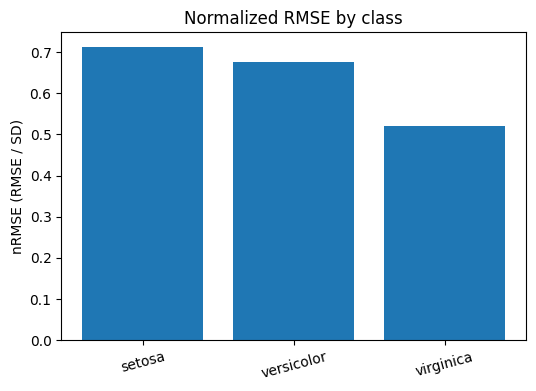

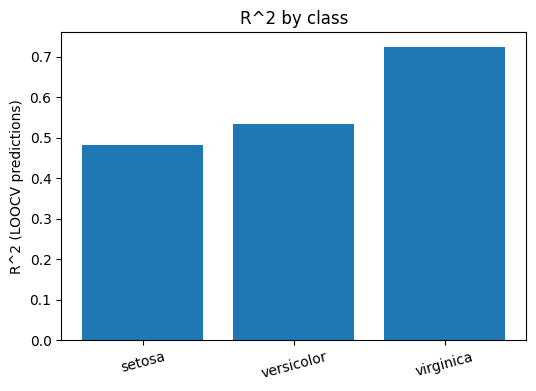

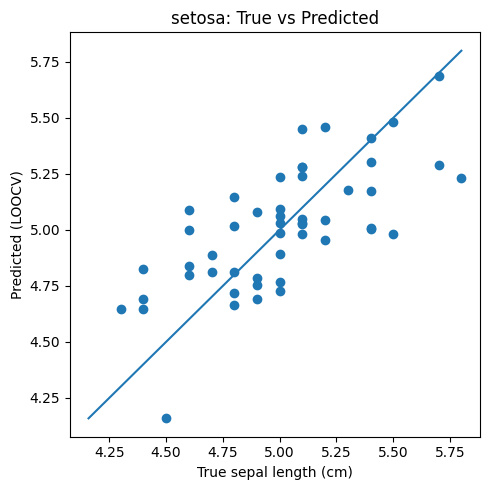

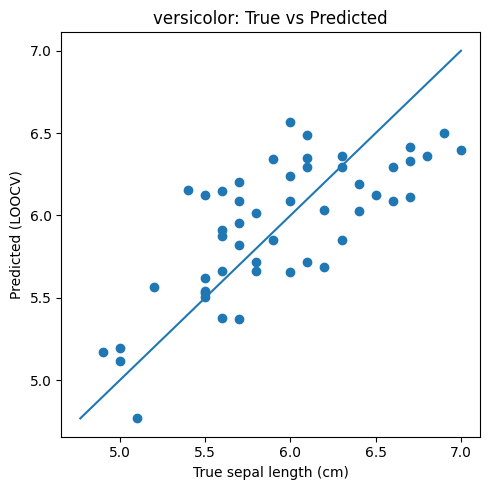

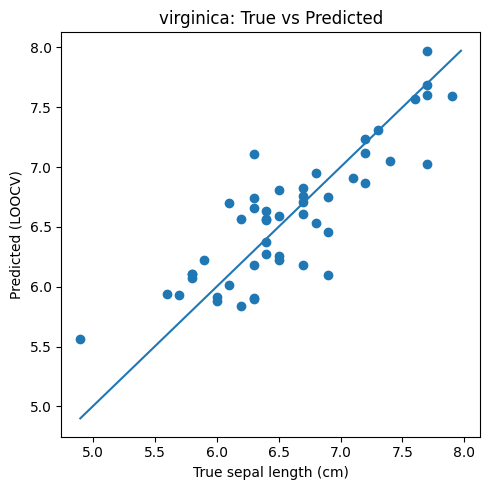

In [9]:
# ---------------------------
# Summary
# ---------------------------

pd.set_option("display.precision", 4)
print("\nPer-class LOOCV regression: predict sepal length from the other three features\n")
print(results.to_string(index=False))

# ---------------------------
# Quick visuals
# ---------------------------
# nRMSE vs class
plt.figure(figsize=(6,4))
plt.bar(results["class"], results["nRMSE"])
plt.ylabel("nRMSE (RMSE / SD)")
plt.title("Normalized RMSE by class")
plt.xticks(rotation=15)
plt.show()

# R^2 vs class
plt.figure(figsize=(6,4))
plt.bar(results["class"], results["R^2"])
plt.ylabel("R^2 (LOOCV predictions)")
plt.title("R^2 by class")
plt.xticks(rotation=15)
plt.show()

# True vs Predicted scatter per class (small multiples)
for label, y_true, y_pred in scatter_payloads:
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred)
    low, high = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    plt.plot([low, high], [low, high])  # 45° line
    plt.xlabel("True sepal length (cm)")
    plt.ylabel("Predicted (LOOCV)")
    plt.title(f"{label}: True vs Predicted")
    plt.tight_layout()
    plt.show()


## Assignment

We have created a new target variable **`y`** as a linear function of two of the original Iris features.  
- The two features are the same across all samples, but the linear weights differ for each species.  
- Because the sample size is small (e.g., only 5 examples per class are shown), it may not be obvious which two features were used by looking at a single class. However, evaluating **MSE / RMSE** errors separately for each class will help you identify the correct pair more clearly.  

The datasets are provided:  
- **Training set** (`iris_train.csv`) — includes the new `y` values.  
  [iris_train.csv](https://github.com/olcaykursun/ML/blob/main/Fall2025/Week5/iris_train.csv)  
- **Test set** (`iris_test.csv`) — does not include `y`.  
  [iris_test.csv](https://github.com/olcaykursun/ML/blob/main/Fall2025/Week5/iris_test.csv)  

### Your Task
1. **Select feature pairs:** Take two features out of the four. Using the training data, build a regression model to predict `y` for each class.  
2. **Test predictions:** Apply your models to the test set and plot **`y` vs. `y_pred`** on the test set.  
3. **Error metrics:** Report the **RMSE** and **nRMSE** of your predictions on the test set.  
4. **Evaluate all subsets:** Repeat Steps 1–3 for all six possible feature pairs. Based on the total MSE of each subset, identify which **two features** were used to construct `y` and clearly report your results.  
5. **Submission requirements:** Submit your Colab notebook with:  
   - Well-commented code  
   - Results shown in the output cells  
   - A short (~5-minute) video explaining your code and results  
